In [11]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

In [12]:
# Load the JSON data
data_file = 'extracted_data_collected_with_logP_and_features.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

In [13]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print('Datapoints after r-product filter: ', len(df_filtered))

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter:  1037


In [14]:
# preprocess data
def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

def preprocess_data(df, target_column):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]

    # Convert temperature lists to mean values
    df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

    # Extract monomer features
    def extract_monomer_features(monomer_data):
        if isinstance(monomer_data, dict):
            return [
                monomer_data.get('ip', None),
                monomer_data.get('ip_corrected', None),
                monomer_data.get('ea', None),
                monomer_data.get('homo', None),
                monomer_data.get('lumo', None),
                monomer_data.get('global_electrophilicity', None),
                monomer_data.get('global_nucleophilicity', None)
            ]
        else:
            return None
    
    df['monomer1_features'] = df['monomer1_data'].apply(extract_monomer_features)
    df['monomer2_features'] = df['monomer2_data'].apply(extract_monomer_features)

    # Drop rows with any missing monomer features
    df.dropna(subset=['monomer1_features', 'monomer2_features'], inplace=True)

    # Handle solvent logP, fill with zeros if logP is missing
    df['solvent_logP'] = df['logP'].fillna(0)

    def normalized_stdev(x):
        return abs(x.std() / x.mean()) if x.mean() != 0 else 0

    # Grouping and aggregating the data
    grouped = df.groupby(['monomer1', 'monomer2', 'solvent', 'temperature']).agg({
        'r1r2': ['mean', 'count', 'std'],
        'monomer1_features': 'first',
        'monomer2_features': 'first',
        'solvent_logP': 'first',
        target_column: ['mean', normalized_stdev]
    })
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.fillna(0, inplace=True)
    grouped_filtered = grouped[grouped[f'{target_column}_normalized_stdev'] < 0.1]

    # Flatten the columns to get rid of the multiindex, keep only the "mean" aggregation
    mean_columns = grouped_filtered.reset_index()
    mean_columns = mean_columns[mean_columns['r1r2_mean'] >= 0]
    
    # Filter out r1r2_mean values greater than 10
    mean_columns = mean_columns[mean_columns['r1r2_mean'] <= 10]

    # Combine monomer features and solvent logP into a feature matrix
    monomer1_features = np.vstack(mean_columns['monomer1_features_first'].values)
    monomer2_features = np.vstack(mean_columns['monomer2_features_first'].values)
    solvent_logP = mean_columns['solvent_logP_first'].values.reshape(-1, 1)
    temperature = mean_columns['temperature'].values.reshape(-1, 1)

    # Combine all features into a single array
    all_features = np.hstack([monomer1_features, monomer2_features, solvent_logP, temperature])

    # Continuous target variable for regression
    regression_labels = mean_columns[f'{target_column}_mean'].values

    labels_class1 = (mean_columns[f'{target_column}_mean'] <= 1).astype(int).values
    labels_class2 = (mean_columns[f'{target_column}_mean'] > 1).astype(int).values

    all_smiles = set(mean_columns['monomer1'].values.tolist() + mean_columns['monomer2'].values.tolist())

    # Stratified split based on the r-product values
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    split_indices = stratified_split.split(mean_columns, mean_columns['r1r2_mean'] > mean_columns['r1r2_mean'].median())

    for train_idx, test_idx in split_indices:
        train_all_features = all_features[train_idx]
        test_all_features = all_features[test_idx]
        train_labels_class1 = labels_class1[train_idx]
        test_labels_class1 = labels_class1[test_idx]
        train_labels_class2 = labels_class2[train_idx]
        test_labels_class2 = labels_class2[test_idx]
        train_regression_labels = regression_labels[train_idx]
        test_regression_labels = regression_labels[test_idx]

    print(f"Lengths of train/test sets: {len(train_all_features)}, {len(test_all_features)}")
    return train_all_features, test_all_features, train_regression_labels, test_regression_labels

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_31844/1475425426.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_31844/1475425426.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

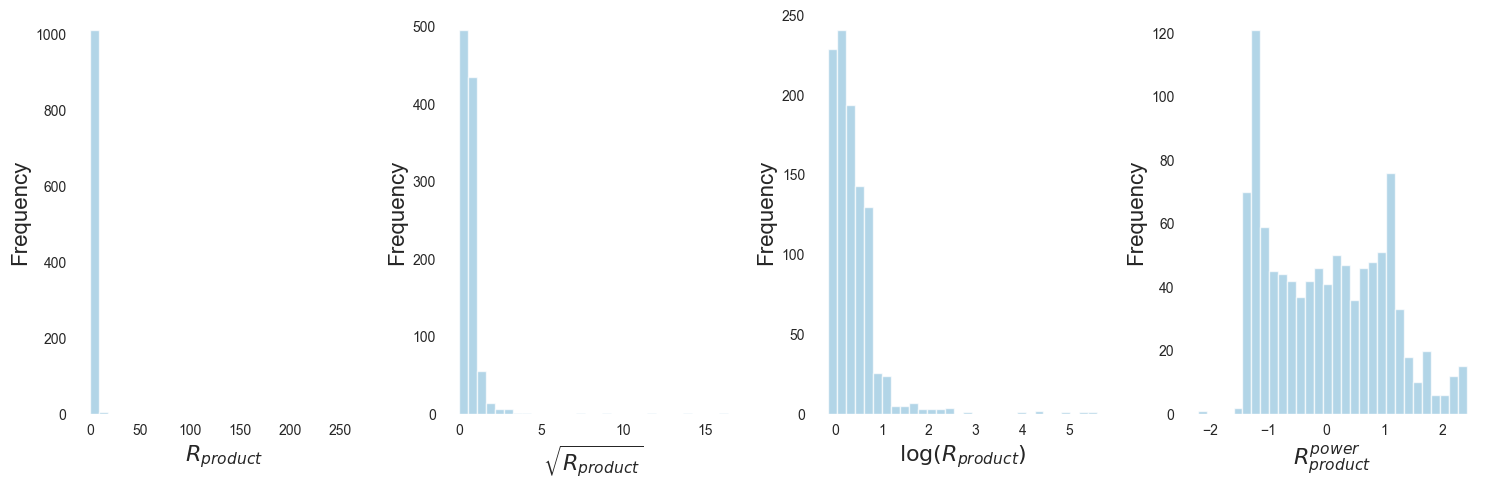

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_31844/2716924400.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_31844/2716924400.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

ValueError: need at least one array to concatenate

In [15]:

# Function to apply Power Transformation
def power_transform(column):
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(column.values.reshape(-1, 1))
    return transformed.flatten()

def preprocess_data_with_transformations(df):
    # Transform r1r2 values
    df['r1r2_sqrt'] = np.sqrt(df['r1r2'])
    df['r1r2_log'] = np.log1p(df['r1r2'])
    df['r1r2_power'] = power_transform(df['r1r2'])
    
    return df

def calculate_r_product(df):
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']
    return df

# Calculate r1r2
df_filtered = calculate_r_product(df_filtered)
# Apply transformations
df_transformed = preprocess_data_with_transformations(df_filtered)

# Train and evaluate Ridge Regression model
def train_and_evaluate(df, target_column, alpha=100.0, n_repeats=10):
    all_train_mse = []
    all_test_mse = []
    all_train_r2 = []
    all_test_r2 = []

    for _ in range(n_repeats):
        train_all_features, test_all_features, train_regression_labels, test_regression_labels = preprocess_data(df, target_column)

        ridge_model = Ridge(alpha=alpha, solver='saga')
        ridge_model.fit(train_all_features, train_regression_labels)

        train_predictions = ridge_model.predict(train_all_features)
        test_predictions = ridge_model.predict(test_all_features)

        train_mse = mean_squared_error(train_regression_labels, train_predictions)
        test_mse = mean_squared_error(test_regression_labels, test_predictions)
        train_r2 = r2_score(train_regression_labels, train_predictions)
        test_r2 = r2_score(test_regression_labels, test_predictions)

        all_train_mse.append(train_mse)
        all_test_mse.append(test_mse)
        all_train_r2.append(train_r2)
        all_test_r2.append(test_r2)

    avg_train_mse = np.mean(all_train_mse)
    avg_test_mse = np.mean(all_test_mse)
    avg_train_r2 = np.mean(all_train_r2)
    avg_test_r2 = np.mean(all_test_r2)

    print(f'Target: {target_column}')
    print(f'Average Training MSE: {avg_train_mse:.4f}, Average Training R2: {avg_train_r2:.4f}')
    print(f'Average Test MSE: {avg_test_mse:.4f}, Average Test R2: {avg_test_r2:.4f}')

def plot_target_distributions(df):
    # Column names based on actual DataFrame columns
    actual_columns = ['r1r2', 'r1r2_sqrt', 'r1r2_log', 'r1r2_power']
    # LaTeX labels for the plots
    target_labels = [r'$R_{product}$', r'$\sqrt{R_{product}}$', r'$\log(R_{product})$', r'$R_{product}^{power}$']
    
    plt.figure(figsize=(15, 5))

    for i, (column, label) in enumerate(zip(actual_columns, target_labels), 1):
        plt.subplot(1, 4, i)
        plt.hist(df[column], bins=30, color='#92C4DE', alpha=0.7)
        plt.xlabel(label, fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        
        plt.grid(False)
        plt.tight_layout()
        plt.gca().set_facecolor('white')
        plt.gcf().set_facecolor('white')

    plt.tight_layout()
    plt.savefig('transfomed_data.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Plot distributions
plot_target_distributions(df_filtered)

# Train and evaluate for different transformations
train_and_evaluate(df_transformed, 'r1r2')
train_and_evaluate(df_transformed, 'r1r2_sqrt')
train_and_evaluate(df_transformed, 'r1r2_log')
train_and_evaluate(df_transformed, 'r1r2_power')
